In [2]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)

library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

# CHR

In [3]:
## CHI_or
n_k_lst=21*abs(c(1:7)-4)+20
pi_k_lst=n_k_lst/sum(n_k_lst)

sd_or_lst=(1+1/c(1:7))
clu_k=rep(c(1:7),each=n_k_lst)
K=length(unique(clu_k))
mu_or=0.325
mu_or_1=mu_or*(1/3)*(1:K)^2
mu_or_2=-mu_or*10*(1:K)^(1/2)

mu_mat_or=cbind(mu_or_1,mu_or_2)
mu_v_or=pi_k_lst%*%mu_mat_or

for(i in 1:K){
    if(i==1){
        m_or=pi_k_lst[i]*mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }else{
        m_or=m_or+pi_k_lst[i]*mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }
}

for(i in 1:K){
    if(i==1){
        wc_or=pi_k_lst[i]*sum(diag(sd_or_lst[i]^2*diag(2)))
    }else{
        wc_or=wc_or+pi_k_lst[i]*sum(diag(sd_or_lst[i]^2*diag(2)))
    }
}

bc_or=sum(diag(m_or-t(mu_v_or)%*%mu_v_or))
wc_or=wc_or
CHI_or=bc_or/wc_or

## CHI_no
mu_no=4
mu_mat_no=mu_no*diag(K)
mu_v_no=apply(mu_mat_no,2,mean)

for(i in 1:K){
    if(i==1){
        m_no=mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }else{
        m_no=m_no+mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }
}
bc_no=sum(diag(m_no/K-mu_v_no%*%t(mu_v_no)))
wc_no=sum(diag(K^(-1)*K*diag(K)))

CHI_no=bc_no/wc_no
cat("CHR:",sqrt(CHI_no/CHI_or))

CHR: 1.002996

# Function

In [4]:
setting_K7_unbalanced<-function(mu_or=1,n_k_lst=21*abs(c(1:7)-4)+20,
                                p=20,seed=1234,mu_no=10){
    set.seed(seed)
    K=length(n_k_lst)
    n=sum(n_k_lst)
    
    for(i in 1:K){
        if(i==1){
            clu_k=c(rep(i,n_k_lst[i]))
        }else{
            clu_k=c(clu_k,rep(i,n_k_lst[i]))
        }
    }
    
    mu_2=mu_or*(1/3)*(clu_k)^2
    mu_3=mu_or*(-10)*(clu_k)^(1/2)
    
    # Data generation
    x2=mu_2+rnorm(n,0,(1+1/clu_k))
    x3=mu_3+rnorm(n,0,(1+1/clu_k))
    
    data_x=scale(cbind(x2,x3))
    
    ############################
    # Data corresponding to nominal clusters
    mu_no_mat=diag(K)
    
    # Nominal cluster generation
    x_no=matrix(0,n,ncol(mu_no_mat))
    p_lst=runif(n,0,1)
    clu_no=p_lst*0
    for(i in 1:K){
        clu_no=clu_no+(p_lst>=((i-1)/K))
    }
    #clu_no
    for(i in 1:nrow(x_no)){
        x_no[i,]=mu_no*mu_no_mat[clu_no[i],]
    }

    for(i in 1:ncol(x_no)){
        x_no[,i]=x_no[,i]+rnorm(nrow(x_no),0,1)
    }

    colnames(x_no)=paste("x_no",1:(ncol(x_no)),sep="_")
    
    ###############################
    # Noise variables
    p_e=p-ncol(data_x)-ncol(x_no)
    noise_mat=nor_minmax(matrix(rnorm(n*p_e,0,1),n,p_e))
    colnames(noise_mat)=paste("noise",1:(ncol(noise_mat)),sep="_")
    
    data=scale(cbind(data_x,x_no,noise_mat))
    
    
    ## clustering
    kk=K
    pam <- pam(data,kk)
    km <- KMeans_rcpp(data,kk)
    mocl <- MOCL_wcss(Xf=data,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=50),delta=0.01)
    skm <- Sparse_km(data=data,kk=kk,nperms_n=10)
    varsel <- VarSelCluster(data, kk, nbcores = 2, crit.varsel = 'BIC') 
    
    
    # clusters
    cluster_mat=rbind(mocl$cluster,
                     skm$cluster_best,
                     skm$cluster_1sd,
                     fitted(varsel),
                     km$cluster,
                     pam$cluster)
    
    rownames(cluster_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    
    sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)),
                    skm$sparse_best,skm$sparse_1sd,
                     slot(slot(varsel,'model'),'omega'))
    
    rownames(sparse_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL")
    
    rand_mat=t(matrix(c(rand.index(clu_k,mocl$cluster),
                         rand.index(clu_k,skm$cluster_best),
                         rand.index(clu_k,skm$cluster_1sd),
                         rand.index(clu_k,fitted(varsel)),
                         rand.index(clu_k,km$cluster),
                         rand.index(clu_k,pam$cluster))))
    
    colnames(rand_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    kendall=cor(clu_k,mocl$cluster,method="kendall")
    
    
    if(p==ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                        c(rep(0,nrow(sparse_mat))))
    }
    if(p>ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                    apply(sparse_mat[,c((ncol(data_x)+1):ncol(sparse_mat))],1,mean))
    }
    
    rand_no=rand.index(clu_k,clu_no)
    return(list(cluster=clu_k,clu_no=clu_no,rand_no=rand_no,cluster_mat=cluster_mat,data=data,mocl_lam=mocl$lambda_sel_mat,
                sparse_mat=sparse_mat,rand_mat=rand_mat,TP_FP_mat=TP_FP_mat,kendall=kendall,
                fx_mocl=mocl$fx,
                coef_mocl=mocl$coef,
                weight_skm=skm$weigth_best,weight_skm_1sd=skm$weigth_1sd))
}

# First 50 iterations

In [5]:
iter_n=50

In [10]:
ss=421
set.seed(ss)
seed_r=seed_r=round(runif(20000,1,30000))

models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()

models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()

mu_ord=0.325

for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_0[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/0.1),seed=seed_rr,mu_no=4)   
}

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+2]
    models_1[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/0.3),seed=seed_rr,mu_no=4)   
}

for(i in 1:iter_n){
    seed_rr=seed_r[11*i+21]
    models_2[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/0.5),seed=seed_rr,mu_no=4)   
}
Sys.time()


Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+142]
    models_3[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/0.7),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+1002]
    models_4[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/0.9),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+2000]
    models_5[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/1.1),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+232]
    models_6[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/1.3),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[11*i+10000]
    models_7[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/1.5),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[11*i+1744]
    models_8[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/1.7),seed=seed_rr,mu_no=4)   
}

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[19*(i-3)+820]
    models_9[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/1.9),seed=seed_rr,mu_no=4)   
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[10*i+33]
    models_10[[i]]=setting_K7_unbalanced(mu_or=mu_ord*(1/2.1),seed=seed_rr,mu_no=4)   
}
Sys.time()


[1] "2024-08-04 21:19:33 KST"

012
012
012
01234
012
012
01234
0123
012
01234
012
012
012345
0123
01234
012
0123
0123
012
01234
012
012
0123
012
0123
012345
01234
012345
012
01
0123
012
01234
012
012
012
012
012345
012
01234
0123
0123
01234
012
01234
01
012
012
0123
012
012345
012
012
012
012
01
012345
0123
012
012
012
012
012345
012345
0123
012
0123
012345
01234
012
012
012
012
012
0123
0123
012
012
012345
012345
012
012
012
012
012
012
012
012
012
012
012
012
012
012
01234
0123
012
0123
012
012


[1] "2024-08-04 21:42:46 KST"

012
012
012
012
012
012
012
012
012345
012
0123
012345
0123
0123
01234
0123
012
012
0123
0123
012
012
0123
01
0123
012
012
012
012
012
012
0123
012
012
012
012345
012
0123
01234
012
012
012
012
012
012
012
012
012
012
01
012
012
0123
01234
012
012
012
012
01234
012
012
0123
01234
0123
012
012
012
012
0123
0123
01234
012
012345
0123
012
012
012
012
01234
0123
0123
012345
01234
012345
012
0123
012
012
012
01234
012
012
012
012
0123
012
01234
012
012345
012


[1] "2024-08-04 22:05:17 KST"

0123
012
012
0123
012
0123
012
012
012
012
01234
012
012
012
012345
012
012
012
012
012
012345
012345
012
012
012
012
0123
0123
012
012
01234
012
012
0123
012
012
012
012
012345
01234
012
012
012345
01
0123
01234
0123
012345
01234
012
0123
012
01
012
012
01234
012
01234
0123
01
0123
0123
012
012
012
012
012
012
01234
012
012
012
012
0123
012345
012
012
012
012345
012345
012
01234
0123
012
012
012
012
012
012
012
0123
012345
012
012
012
012
012
012
012
012


[1] "2024-08-04 22:27:12 KST"

012
01234
012
012
0123
012
0123
012345
012
012
0123
01
0123
01234
01234
012
012
012
012345
0123
012
01234
0123
0123
012345
012345
012345
01
012
012
012
012
012
012
012
012
012
012
0123
0123
012
012
0123
012345
012
012345
0123
012345
0123
012345
012
012
012
012
012
012
012
012
01234
012
0123
0123
01234
012345
012
012
01
012
012345
012
0123
012
012
012
012
012
01234
012345
012
012
012
012
0123
01
01234
01234
012
012
012
012
012
012
0123
012345
012
012
0123
012345
012
012


[1] "2024-08-04 22:48:58 KST"

012
01234
012
012
012
012
012
012
012
012
012
012
012
01234
012
0123
012
0123
0123
012
012
012
012345
012345
012
012345
0123
0123
01234
012
01234
01234
0123
01
012
012
012
012
0123
012
0123
01234
012345
012
012
012
012
012
01234
012
012345
012
012
012
0123
01234
01234
012
012345
012
01234
0123
012
012
012
01
01234
012
012
0123
012
012
012
012
012345
012
012
012
012
012
01234
01234
0123
012
012
0123
012
0123
012345
012345
012
012
012
012345
0123
012345
012
012
012
012


[1] "2024-08-04 23:11:06 KST"

012
012
01234
012345
012
012
0123
01234
012345
01
012
0123


ERROR: Error in lambda_sel_mat_opt[3, ]: incorrect number of dimensions


In [26]:
length(models_10)

[1] 50

# Results

In [27]:
mm_lst_or_1=list()
mm_lst_or_1[[1]]=models_0
mm_lst_or_1[[2]]=models_1
mm_lst_or_1[[3]]=models_2
mm_lst_or_1[[4]]=models_3
mm_lst_or_1[[5]]=models_4
mm_lst_or_1[[6]]=models_5
mm_lst_or_1[[7]]=models_6
mm_lst_or_1[[8]]=models_7
mm_lst_or_1[[9]]=models_8
mm_lst_or_1[[10]]=models_9
mm_lst_or_1[[11]]=models_10

In [31]:
saveRDS(mm_lst_or_1,file="add_simul_or_1.RData")

In [52]:
mm_lst=mm_lst_or_1

In [53]:
for(i in 1:length(mm_lst)){
    if(i==1){
        rand_mat=round(rand_summary(mm_lst[[i]])$rand_mean,3)
    }else{
        rand_mat=rbind(rand_mat,round(rand_summary(mm_lst[[i]])$rand_mean,3))
    }
}

for(i in 1:length(mm_lst)){
    if(i==1){
        rand_no_mat=round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3)
    }else{
        rand_no_mat=rbind(rand_no_mat,round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3))
    }
}



In [54]:
var_acc<-function(models,index=c(1,2,3)){
    for(i in 1:length(models)){
        if(i==1){
            acc=apply(models[[i]]$sparse_mat[,index],1,mean)
        }else{
            acc=rbind(acc,apply(models[[i]]$sparse_mat[,index],1,mean))
        }
    }
    acc_mean=apply(acc,2,mean)
    return(acc_mean)
}

In [55]:
for(i in 1:length(mm_lst)){
    if(i==1){
        tp_ord=var_acc(models=mm_lst[[i]],index=c(1,2))
        tp_nom=var_acc(models=mm_lst[[i]],index=c(3:9))
        tp_noi=var_acc(models=mm_lst[[i]],index=c(10:20))
    }else{
        tp_ord=rbind(tp_ord,var_acc(models=mm_lst[[i]],index=c(1,2)))
        tp_nom=rbind(tp_nom,var_acc(models=mm_lst[[i]],index=c(3:9)))
        tp_noi=rbind(tp_noi,var_acc(models=mm_lst[[i]],index=c(10:20)))
    }
}

# Plots

## Rand index

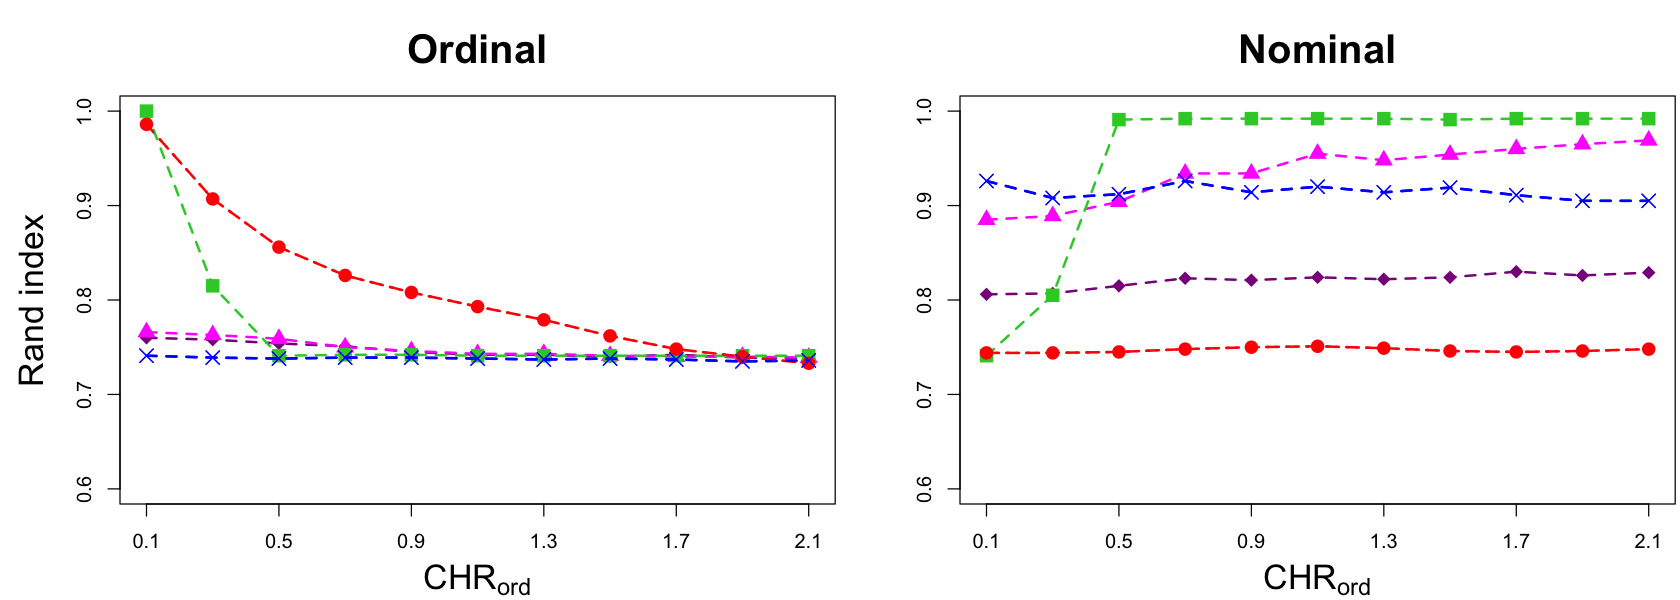

In [57]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="Ordinal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

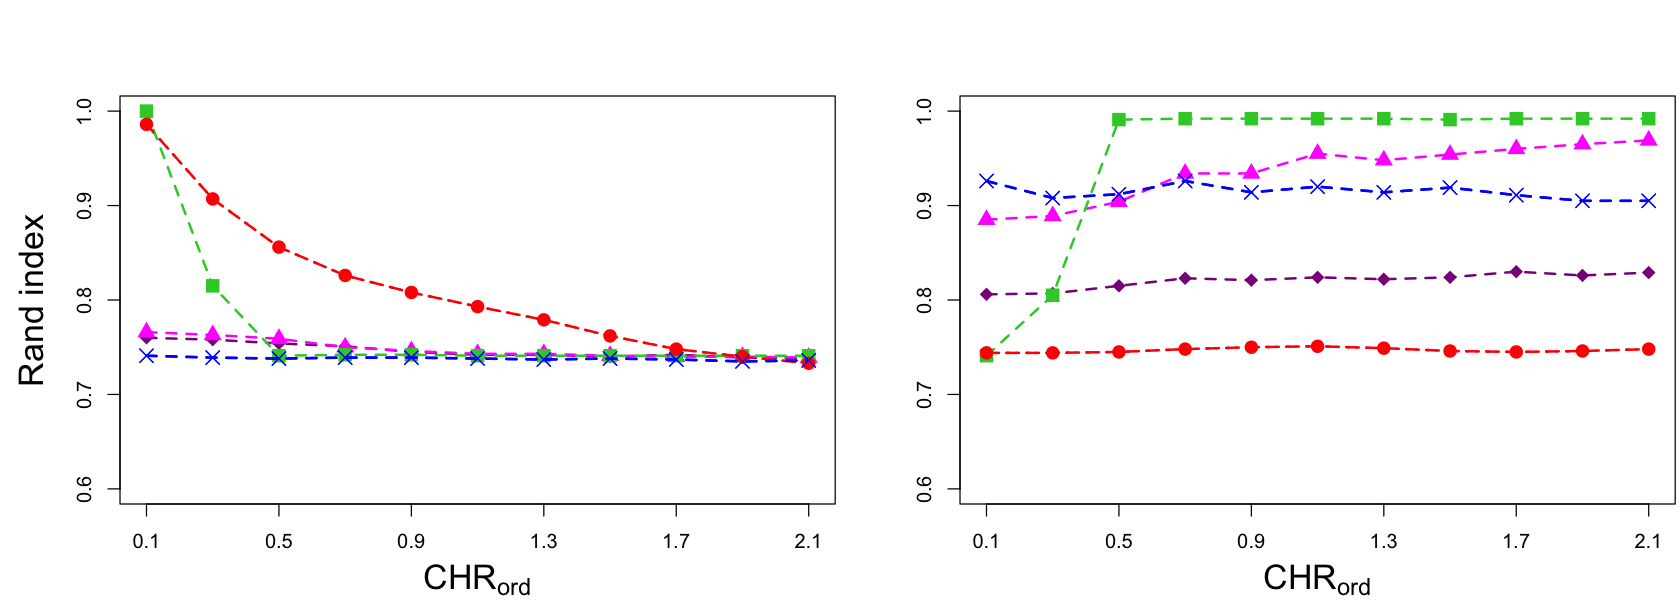

In [58]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

## Variable selection

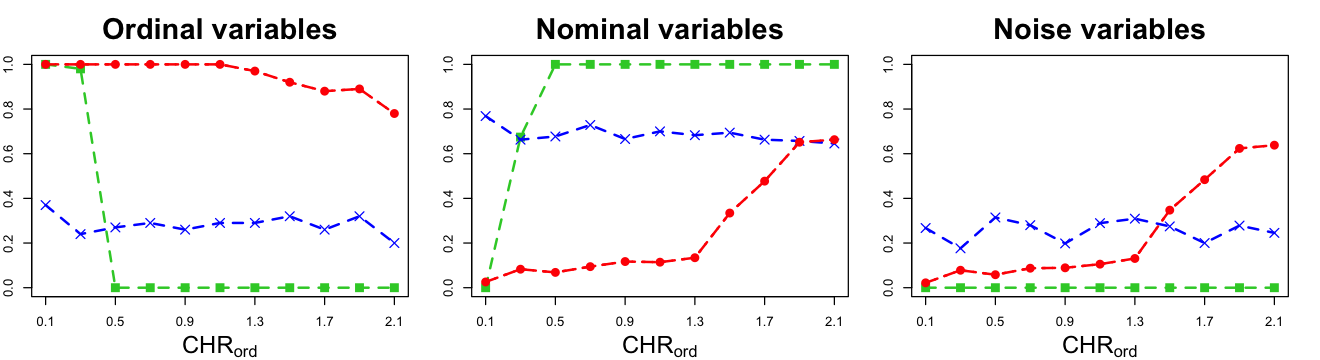

In [59]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Ordinal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Noise variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

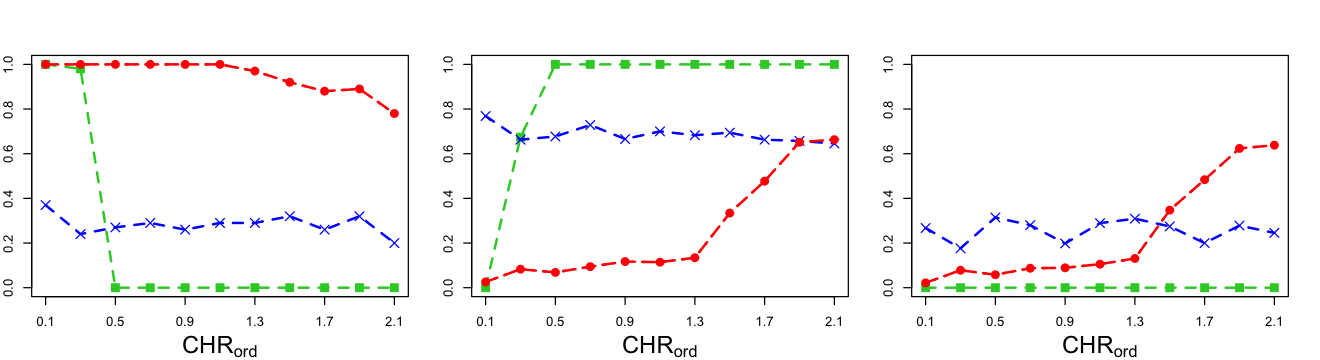

In [60]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}